<a href="https://colab.research.google.com/github/BiharaCD/PGGAN---ShapesGAN/blob/main/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1 — check GPU & install required libs (run once)
import torch, sys
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# Install any missing libs (uncomment if colab lacks them)
# !pip install --upgrade torch torchvision tqdm


PyTorch version: 2.8.0+cu126
CUDA available: True Device: Tesla T4


In [2]:
# Cell 2 — upload and unzip (manual upload via file picker)
from google.colab import files
uploaded = files.upload()   # click and upload shapes_gan.zip
# After upload, unzip:
import zipfile, os
zip_path = next(iter(uploaded.keys()))
print("Uploaded:", zip_path)
!unzip -q "{zip_path}" -d ./shapes_gan_unzipped
print("Unzipped to ./shapes_gan_unzipped. Files:")
!find ./shapes_gan_unzipped -maxdepth 2 -type f | head -n 20


Saving shapes_gan.zip to shapes_gan (1).zip
Uploaded: shapes_gan (1).zip
Unzipped to ./shapes_gan_unzipped. Files:
./shapes_gan_unzipped/train/img_01297.png
./shapes_gan_unzipped/train/img_00033.png
./shapes_gan_unzipped/train/img_01328.png
./shapes_gan_unzipped/train/img_00735.png
./shapes_gan_unzipped/train/img_01543.png
./shapes_gan_unzipped/train/img_00231.png
./shapes_gan_unzipped/train/img_00303.png
./shapes_gan_unzipped/train/img_01756.png
./shapes_gan_unzipped/train/img_01649.png
./shapes_gan_unzipped/train/img_00549.png
./shapes_gan_unzipped/train/img_00601.png
./shapes_gan_unzipped/train/img_00791.png
./shapes_gan_unzipped/train/img_01334.png
./shapes_gan_unzipped/train/img_01424.png
./shapes_gan_unzipped/train/img_00243.png
./shapes_gan_unzipped/train/img_01023.png
./shapes_gan_unzipped/train/img_00995.png
./shapes_gan_unzipped/train/img_00481.png
./shapes_gan_unzipped/train/img_01674.png
./shapes_gan_unzipped/train/img_01312.png


In [3]:
# Cell 3 — dataset + helper DataLoader factory
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import glob, random, torch

class ShapesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # expects root_dir contains "train" (and optional "val")
        self.paths = sorted(glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

def get_dataloader(folder, resolution, batch_size, shuffle=True, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)  # [-1,1]
    ])
    ds = ShapesDataset(folder, transform=transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)

# Example:
# dl = get_dataloader("./shapes_gan_unzipped/train", 64, 16)
# print(len(dl.dataset))


In [10]:
# Cell 4 — Progressive Generator + Discriminator (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# Utility blocks
def conv3x3(in_c, out_c, stride=1):
    return nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)

class PixelNorm(nn.Module):
    def __init__(self, eps=1e-8): super().__init__(); self.eps = eps
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.eps)

class GenInitialBlock(nn.Module):
    def __init__(self, z_dim, out_channels):
        super().__init__()
        self.fc = nn.Linear(z_dim, out_channels*4*4)
        self.conv = conv3x3(out_channels, out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
    def forward(self, z):
        x = self.fc(z).view(z.size(0), -1, 4, 4)
        x = self.lrelu(self.conv(self.pn(x)))
        return x

class GenGeneralBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = conv3x3(in_c, out_c)
        self.conv2 = conv3x3(out_c, out_c)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
    def forward(self, x):
        x = self.upsample(x)
        x = self.lrelu(self.conv1(self.pn(x)))
        x = self.lrelu(self.conv2(self.pn(x)))
        return x

class ToRGB(nn.Module):
    def __init__(self, in_c): super().__init__(); self.conv = nn.Conv2d(in_c, 3, kernel_size=1)
    def forward(self, x): return self.conv(x)

class ProgressiveGenerator(nn.Module):
    def __init__(self, z_dim=128, fmap_max=512, fmap_base=512, device='cuda'):
        super().__init__()
        self.z_dim = z_dim
        # channels per resolution: 4->512 ... 64->64
        self.channels = {4:512, 8:512, 16:256, 32:128, 64:64}
        self.initial = GenInitialBlock(z_dim, self.channels[4])
        # store blocks and toRGB per resolution
        self.blocks = nn.ModuleList()
        self.to_rgbs = nn.ModuleList([ToRGB(self.channels[4])])  # for 4x4
        # create blocks for 8,16,32,64
        res_list = [8,16,32,64]
        prev_c = self.channels[4]
        for r in res_list:
            c = self.channels[r]
            self.blocks.append(GenGeneralBlock(prev_c, c))
            self.to_rgbs.append(ToRGB(c))
            prev_c = c
        self.device = device

    def forward(self, z, step, alpha):
        """
        step: 0 -> 4x4; 1 -> 8x8; 2 -> 16x16; 3 -> 32x32; 4 -> 64x64
        alpha: fade-in value [0,1] during transition; 1 for stable
        """
        x = self.initial(z)                       # 4x4
        if step == 0:
            return torch.tanh(self.to_rgbs[0](x))
        # iterate blocks up to step-1 (because blocks[0] produces 8x8 from 4x4)
        for i in range(step):
            x = self.blocks[i](x)
            # if we're at the block that is being faded-in (i == step-1), apply alpha blending
            if i == step-1 and 0 <= alpha < 1.0:
                # old path: upsample previous 4x4->8x8 etc
                prev_rgb = self.to_rgbs[i](nn.functional.interpolate(self.initial(z) if i==0 else prev_x, scale_factor=2**(i+1), mode='nearest'))
                new_rgb = self.to_rgbs[i+1](x)
                return torch.tanh(alpha * new_rgb + (1-alpha) * prev_rgb)
            prev_x = x
        return torch.tanh(self.to_rgbs[step](x))


# Discriminator part
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        batch, c, h, w = x.shape
        std = torch.std(x, dim=0, unbiased=False)  # shape (c,h,w)
        mean_std = std.mean().view(1,1,1,1).expand(batch,1,h,w)
        return torch.cat([x, mean_std], dim=1)

class DiscGeneralBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = conv3x3(in_c, in_c)
        self.conv2 = conv3x3(in_c, out_c)
        self.downsample = nn.AvgPool2d(2)
        self.lrelu = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.downsample(x)
        return x

class FromRGB(nn.Module):
    def __init__(self, out_c):
        super().__init__()
        self.conv = nn.Conv2d(3, out_c, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class ProgressiveDiscriminator(nn.Module):
    def __init__(self, fmap_max=512):
        super().__init__()
        self.channels = {4:512, 8:512, 16:256, 32:128, 64:64}
        # fromRGB layers for each resolution (reverse order for convenience)
        self.from_rgbs = nn.ModuleList([FromRGB(self.channels[r]) for r in (4,8,16,32,64)])
        # blocks from high res -> down to 4x4. blocks[0] reduces 64->32 etc.
        self.blocks = nn.ModuleList()
        res_pairs = [(64,32),(32,16),(16,8),(8,4)]
        for high, low in res_pairs:
            self.blocks.append(DiscGeneralBlock(self.channels[high], self.channels[low]))
        # final conv and dense
        self.mbstd = MinibatchStdDev()
        self.conv_final = conv3x3(self.channels[4]+1, self.channels[4])
        self.fc = nn.Linear(self.channels[4]*4*4, 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x, step, alpha):
        """
        step: 0 -> 4x4; 1 -> 8x8; ... 4 -> 64x64
        alpha: fade-in factor during transition
        """
        # If step==0, directly fromRGB 4x4
        if step == 0:
            out = self.from_rgbs[0](x)
            out = self.lrelu(self.conv_final(self.mbstd(out)))
            out = out.view(out.size(0), -1)
            return self.fc(out)

        # Get which fromRGB to use for current highest resolution
        idx = step  # index in from_rgbs (0->4x4, 1->8x8,...)
        # new path: input -> fromRGB at current resolution -> blocks down to 4x4
        new = self.from_rgbs[idx](x)
        ################## if fading in, also compute downsampled old path and blend
        if alpha < 1.0:
           down_x = nn.functional.avg_pool2d(x, kernel_size=2)
           old = self.from_rgbs[idx-1](down_x)
           old_upsampled = nn.functional.interpolate(old, scale_factor=2, mode='nearest')
           new = alpha * new + (1 - alpha) * old_upsampled


        # pass through blocks from current resolution down to 4x4
        out = new
        # blocks are ordered 64->32, 32->16, 16->8, 8->4 but step tells how many to apply
        for i in range(step-1, -1, -1):
            # map i index to block index: when step==4 we need to run blocks[0] first (64->32)
            block_idx = (step-1) - i
            out = self.blocks[block_idx](out)
        out = self.lrelu(self.conv_final(self.mbstd(out)))
        out = out.view(out.size(0), -1)
        return self.fc(out)


corrected cell4

In [13]:
# Cell 4 — Progressive Generator + Discriminator (PyTorch)  (CORRECTED)
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# Utility blocks
def conv3x3(in_c, out_c, stride=1):
    return nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)

class PixelNorm(nn.Module):
    def __init__(self, eps=1e-8): super().__init__(); self.eps = eps
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.eps)

class GenInitialBlock(nn.Module):
    def __init__(self, z_dim, out_channels):
        super().__init__()
        self.fc = nn.Linear(z_dim, out_channels*4*4)
        self.conv = conv3x3(out_channels, out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
    def forward(self, z):
        x = self.fc(z).view(z.size(0), -1, 4, 4)
        x = self.lrelu(self.conv(self.pn(x)))
        return x

class GenGeneralBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = conv3x3(in_c, out_c)
        self.conv2 = conv3x3(out_c, out_c)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
    def forward(self, x):
        x = self.upsample(x)
        x = self.lrelu(self.conv1(self.pn(x)))
        x = self.lrelu(self.conv2(self.pn(x)))
        return x

class ToRGB(nn.Module):
    def __init__(self, in_c): super().__init__(); self.conv = nn.Conv2d(in_c, 3, kernel_size=1)
    def forward(self, x): return self.conv(x)

class ProgressiveGenerator(nn.Module):
    def __init__(self, z_dim=128, device='cuda'):
        super().__init__()
        self.z_dim = z_dim
        # channels per resolution: 4->512, 8->512, 16->256, 32->128, 64->64
        self.resolutions = [4,8,16,32,64]
        self.channels = {4:512, 8:512, 16:256, 32:128, 64:64}
        self.initial = GenInitialBlock(z_dim, self.channels[4])
        # store blocks and toRGB per resolution
        self.blocks = nn.ModuleList()
        self.to_rgbs = nn.ModuleList([ToRGB(self.channels[4])])  # for 4x4
        # create blocks for 8,16,32,64
        prev_c = self.channels[4]
        for r in self.resolutions[1:]:
            c = self.channels[r]
            self.blocks.append(GenGeneralBlock(prev_c, c))
            self.to_rgbs.append(ToRGB(c))
            prev_c = c
        self.device = device

    def forward(self, z, step, alpha):
        """
        step: 0 -> 4x4; 1 -> 8x8; 2 -> 16x16; 3 -> 32x32; 4 -> 64x64
        alpha: fade-in value [0,1] during transition; 1 for stable
        """
        x = self.initial(z)                       # 4x4
        if step == 0:
            return torch.tanh(self.to_rgbs[0](x))
        prev_x = None
        for i in range(step):
            prev_x = x
            x = self.blocks[i](x)
            # fade-in at the block being added (i == step-1)
            if i == step-1 and 0 <= alpha < 1.0:
                # previous RGB (upsample prev_x then toRGB of prev level)
                prev_rgb = self.to_rgbs[i](nn.functional.interpolate(prev_x, scale_factor=2, mode='nearest'))
                new_rgb = self.to_rgbs[i+1](x)
                return torch.tanh(alpha * new_rgb + (1 - alpha) * prev_rgb)
        return torch.tanh(self.to_rgbs[step](x))


# Discriminator part
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        batch, c, h, w = x.shape
        std = torch.std(x, dim=0, unbiased=False)  # shape (c,h,w)
        mean_std = std.mean().view(1,1,1,1).expand(batch,1,h,w)
        return torch.cat([x, mean_std], dim=1)

class DiscGeneralBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # in_c := channels at current (higher) resolution
        # out_c := channels at next (lower) resolution (after downsampling)
        self.conv1 = conv3x3(in_c, in_c)
        self.conv2 = conv3x3(in_c, out_c)
        self.downsample = nn.AvgPool2d(2)
        self.lrelu = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.downsample(x)
        return x

class FromRGB(nn.Module):
    def __init__(self, out_c):
        super().__init__()
        self.conv = nn.Conv2d(3, out_c, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class ProgressiveDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # same resolution-channel mapping as generator
        self.resolutions = [4,8,16,32,64]
        self.channels = {4:512, 8:512, 16:256, 32:128, 64:64}
        # fromRGB layers for each resolution in increasing order (4,8,16,32,64)
        self.from_rgbs = nn.ModuleList([FromRGB(self.channels[r]) for r in self.resolutions])
        # blocks list: from highest resolution -> down to 4x4
        # we create blocks for pairs: (64->32), (32->16), (16->8), (8->4) in that order
        self.blocks = nn.ModuleList()
        res_pairs = [(64,32),(32,16),(16,8),(8,4)]
        for high, low in res_pairs:
            self.blocks.append(DiscGeneralBlock(self.channels[high], self.channels[low]))
        # final conv and dense (for 4x4)
        self.mbstd = MinibatchStdDev()
        self.conv_final = conv3x3(self.channels[4] + 1, self.channels[4])
        self.fc = nn.Linear(self.channels[4]*4*4, 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x, step, alpha):
        """
        step: 0 -> 4x4; 1 -> 8x8; 2 -> 16x16; 3 -> 32x32; 4 -> 64x64
        alpha: fade-in factor during transition
        """
        # step 0: directly 4x4 path
        if step == 0:
            out = self.from_rgbs[0](x)            # map RGB->features for 4x4
            out = self.lrelu(self.conv_final(self.mbstd(out)))
            out = out.view(out.size(0), -1)
            return self.fc(out)

        # index in resolutions/from_rgbs for current step
        idx = step  # 1->8, 2->16, ...
        # new path: use from_rgb at current resolution
        new = self.from_rgbs[idx](x)   # shape (N, channels[idx], H, W)

        # fade-in blending: get old path from lower resolution, upsample it,
        # then align channels (truncate or pad) before blending.
        if alpha < 1.0:
            # downsample image (RGB) to previous resolution and convert
            down_x = F.avg_pool2d(x, kernel_size=2)
            old = self.from_rgbs[idx-1](down_x)   # shape (N, channels[idx-1], H/2, W/2)
            old_upsampled = F.interpolate(old, scale_factor=2, mode='nearest')  # (N, c_old, H, W)

            # align channels between old_upsampled and new (simple deterministic map)
            c_new = new.shape[1]
            c_old = old_upsampled.shape[1]
            if c_old > c_new:
                old_upsampled = old_upsampled[:, :c_new, :, :]
            elif c_old < c_new:
                pad = torch.zeros(old_upsampled.size(0), c_new - c_old, old_upsampled.size(2), old_upsampled.size(3), device=old_upsampled.device)
                old_upsampled = torch.cat([old_upsampled, pad], dim=1)

            new = alpha * new + (1 - alpha) * old_upsampled

        # Now pass through the correct sequence of blocks from current resolution down to 4x4.
        # blocks list is ordered: [ (64->32), (32->16), (16->8), (8->4) ]
        # For a given step, we need to apply the LAST `step` blocks (because step counts up from 4).
        # Example: step=1 (8x8) -> apply only blocks[3] (8->4)
        #          step=4 (64x64) -> apply blocks[0], blocks[1], blocks[2], blocks[3]
        total_blocks = len(self.blocks)
        start_idx = total_blocks - step      # starting block index to run
        out = new
        for j in range(start_idx, total_blocks):
            out = self.blocks[j](out)

        out = self.lrelu(self.conv_final(self.mbstd(out)))
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [14]:
# Cell 5 — helpers: init weights, gradient penalty, saving samples
import torch.autograd as autograd
import torchvision.utils as vutils
import os

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def compute_gradient_penalty(D, real_samples, fake_samples, step, alpha, device='cuda', lambda_gp=10.0):
    batch_size = real_samples.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolates = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolates.requires_grad_(True)
    d_interpolates = D(interpolates, step, alpha)
    grads = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                          grad_outputs=torch.ones_like(d_interpolates),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads = grads.view(grads.size(0), -1)
    grad_norm = grads.norm(2, dim=1)
    gp = lambda_gp * ((grad_norm - 1) ** 2).mean()
    return gp

def save_image_grid(tensor, filename, nrow=8):
    # tensor in range [-1,1]
    grid = vutils.make_grid((tensor+1)/2, nrow=nrow, padding=2, normalize=False)
    vutils.save_image(grid, filename)


In [15]:
# Cell 6 — training loop (progressive)
import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams (change as needed)
z_dim = 128
batch_size = 16
n_critic = 1
lr = 1e-4
betas = (0.0, 0.99)
lambda_gp = 10.0

# progressive schedule
resolutions = [4,8,16,32,64]
max_step = len(resolutions)-1

# epochs per phase — small for example, increase for real training
transition_epochs = 3     # fade-in epochs
stabilize_epochs = 3      # epochs after fade finishes
save_dir = "./pgan_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# init models
G = ProgressiveGenerator(z_dim=z_dim, device=device).to(device)
D = ProgressiveDiscriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

fixed_z = torch.randn(16, z_dim, device=device)

global_step = 0
for step, resolution in enumerate(resolutions):
    print(f"\n*** Training at resolution {resolution}x{resolution} (step {step}) ***")
    # build dataloader for this resolution
    data_folder = "./shapes_gan_unzipped/train"  # modify if needed
    dl = get_dataloader(data_folder, resolution, batch_size, shuffle=True)
    iters_per_epoch = len(dl)
    # PHASE 1: transition (fade-in)
    for phase, epochs in [("transition", transition_epochs), ("stabilize", stabilize_epochs)]:
        print(f" Phase: {phase} for {epochs} epochs")
        for epoch in range(epochs):
            pbar = tqdm(dl, desc=f"Res{resolution} E{epoch+1}/{epochs}")
            alpha = 0.0 if phase=="transition" else 1.0
            # if transition, we increase alpha gradually over batches
            if phase == "transition":
                total_transition_steps = transition_epochs * iters_per_epoch
                alpha_step = 1.0 / (total_transition_steps + 1e-8)
            for imgs in pbar:
                imgs = imgs.to(device)
                batch_size_cur = imgs.size(0)
                # update alpha if in transition
                if phase == "transition":
                    alpha = min(1.0, alpha + alpha_step)
                # ---------------------
                #  Train Discriminator (WGAN-GP)
                # ---------------------
                z = torch.randn(batch_size_cur, z_dim, device=device)
                fake_imgs = G(z, step, alpha).detach()
                D_real = D(imgs, step, alpha)
                D_fake = D(fake_imgs, step, alpha)
                gp = compute_gradient_penalty(D, imgs.data, fake_imgs.data, step, alpha, device, lambda_gp)
                d_loss = (D_fake.mean() - D_real.mean()) + gp
                opt_D.zero_grad(); d_loss.backward(); opt_D.step()
                # ---------------------
                #  Train Generator
                # ---------------------
                if global_step % n_critic == 0:
                    z = torch.randn(batch_size_cur, z_dim, device=device)
                    fake_imgs = G(z, step, alpha)
                    g_loss = -D(fake_imgs, step, alpha).mean()
                    opt_G.zero_grad(); g_loss.backward(); opt_G.step()

                global_step += 1
                if global_step % 200 == 0:
                    # save sample
                    G.eval()
                    with torch.no_grad():
                        samples = G(fixed_z, step, alpha).cpu()
                        save_image_grid(samples, f"{save_dir}/sample_step{global_step}_res{resolution}.png", nrow=4)
                    G.train()
                # tqdm postfix
                pbar.set_postfix({'d_loss': f"{d_loss.item():.4f}", 'g_loss': f"{(g_loss.item() if 'g_loss' in locals() else 0):.4f}", 'alpha': f"{alpha:.3f}"})
            # end epoch
        # end phase
    # after finishing this resolution:
    torch.save({'G_state': G.state_dict(), 'D_state': D.state_dict(), 'opt_G': opt_G.state_dict(), 'opt_D': opt_D.state_dict(), 'step': step}, f"{save_dir}/pgan_checkpoint_res{resolution}.pt")
    print(f"Saved checkpoint for resolution {resolution}")
# done all resolutions
print("Training finished (all scheduled resolutions).")



*** Training at resolution 4x4 (step 0) ***
 Phase: transition for 3 epochs


Res4 E3/3: 100%|██████████| 125/125 [00:03<00:00, 37.66it/s, d_loss=-0.3543, g_loss=2.1870, alpha=0.333]


 Phase: stabilize for 3 epochs


Res4 E3/3: 100%|██████████| 125/125 [00:02<00:00, 46.35it/s, d_loss=-0.4458, g_loss=0.5253, alpha=1.000]


Saved checkpoint for resolution 4

*** Training at resolution 8x8 (step 1) ***
 Phase: transition for 3 epochs


Res8 E3/3: 100%|██████████| 125/125 [00:07<00:00, 17.66it/s, d_loss=4.2613, g_loss=-2.6607, alpha=0.333]


 Phase: stabilize for 3 epochs


Res8 E3/3: 100%|██████████| 125/125 [00:06<00:00, 18.13it/s, d_loss=0.5040, g_loss=0.1050, alpha=1.000]


Saved checkpoint for resolution 8

*** Training at resolution 16x16 (step 2) ***
 Phase: transition for 3 epochs


Res16 E3/3: 100%|██████████| 125/125 [00:12<00:00, 10.25it/s, d_loss=6.4558, g_loss=-0.1853, alpha=0.333]


 Phase: stabilize for 3 epochs


Res16 E3/3: 100%|██████████| 125/125 [00:11<00:00, 10.76it/s, d_loss=0.5982, g_loss=1.2533, alpha=1.000]


Saved checkpoint for resolution 16

*** Training at resolution 32x32 (step 3) ***
 Phase: transition for 3 epochs


Res32 E3/3: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s, d_loss=7.2397, g_loss=-2.8322, alpha=0.333]


 Phase: stabilize for 3 epochs


Res32 E3/3: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, d_loss=0.2604, g_loss=-0.1100, alpha=1.000]


Saved checkpoint for resolution 32

*** Training at resolution 64x64 (step 4) ***
 Phase: transition for 3 epochs


Res64 E3/3: 100%|██████████| 125/125 [00:33<00:00,  3.71it/s, d_loss=7.1210, g_loss=-1.8066, alpha=0.333]


 Phase: stabilize for 3 epochs


Res64 E3/3: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s, d_loss=-9.8764, g_loss=-96.4828, alpha=1.000]


Saved checkpoint for resolution 64
Training finished (all scheduled resolutions).


update cell 6

In [17]:
# =========================
# Progressive GAN Training Loop (Corrected & Updated)
# =========================

import time
from tqdm import tqdm
import os
import torch
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Hyperparameters
# -------------------------
z_dim = 128
batch_size = 16
n_critic = 1
lr = 1e-4
betas = (0.0, 0.99)
lambda_gp = 10.0

resolutions = [4, 8, 16, 32, 64]
max_step = len(resolutions) - 1

transition_epochs = 3     # fade-in epochs
stabilize_epochs = 3      # stabilize epochs
save_dir = "./pgan_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# -------------------------
# Initialize models
# -------------------------
G = ProgressiveGenerator(z_dim=z_dim, device=device).to(device)
D = ProgressiveDiscriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

fixed_z = torch.randn(16, z_dim, device=device)

global_step = 0

# -------------------------
# Start progressive training
# -------------------------
for step, resolution in enumerate(resolutions):
    print(f"\n*** Training at resolution {resolution}x{resolution} (step {step}) ***")

    data_folder = "./shapes_gan_unzipped/train"  # Update if needed
    dl = get_dataloader(data_folder, resolution, batch_size, shuffle=True)
    iters_per_epoch = len(dl)

    # PHASES: transition -> stabilize
    for phase, epochs in [("transition", transition_epochs), ("stabilize", stabilize_epochs)]:
        print(f" Phase: {phase} for {epochs} epochs")
        for epoch in range(epochs):
            pbar = tqdm(dl, desc=f"Res{resolution} E{epoch+1}/{epochs}")
            alpha = 0.0 if phase == "transition" else 1.0

            if phase == "transition":
                total_transition_steps = transition_epochs * iters_per_epoch
                alpha_step = 1.0 / (total_transition_steps + 1e-8)

            for imgs in pbar:
                imgs = imgs.to(device)
                batch_size_cur = imgs.size(0)

                # Update alpha during transition
                if phase == "transition":
                    alpha = min(1.0, alpha + alpha_step)

                # -------------------------
                # Train Discriminator (WGAN-GP)
                # -------------------------
                z = torch.randn(batch_size_cur, z_dim, device=device)
                fake_imgs = G(z, step, alpha).detach()
                D_real = D(imgs, step, alpha)
                D_fake = D(fake_imgs, step, alpha)
                gp = compute_gradient_penalty(D, imgs.data, fake_imgs.data, step, alpha, device, lambda_gp)
                d_loss = (D_fake.mean() - D_real.mean()) + gp

                opt_D.zero_grad()
                d_loss.backward()
                opt_D.step()

                # -------------------------
                # Train Generator
                # -------------------------
                if global_step % n_critic == 0:
                    z = torch.randn(batch_size_cur, z_dim, device=device)
                    fake_imgs = G(z, step, alpha)
                    g_loss = -D(fake_imgs, step, alpha).mean()

                    opt_G.zero_grad()
                    g_loss.backward()
                    opt_G.step()

                global_step += 1

                # -------------------------
                # Save sample images every 200 steps
                # -------------------------
                if global_step % 200 == 0:
                    G.eval()
                    with torch.no_grad():
                        samples = G(fixed_z, step, alpha).cpu()
                        save_image((samples + 1) / 2.0, f"{save_dir}/sample_step{global_step}_res{resolution}.png", nrow=4)
                    G.train()

                # Update progress bar
                pbar.set_postfix({
                    'd_loss': f"{d_loss.item():.4f}",
                    'g_loss': f"{(g_loss.item() if 'g_loss' in locals() else 0):.4f}",
                    'alpha': f"{alpha:.3f}"
                })

    # -------------------------
    # Save checkpoint after each resolution
    # -------------------------
    torch.save({
        'G_state': G.state_dict(),
        'D_state': D.state_dict(),
        'opt_G': opt_G.state_dict(),
        'opt_D': opt_D.state_dict(),
        'step': step
    }, f"{save_dir}/pgan_checkpoint_res{resolution}.pt")

    print(f"Saved checkpoint for resolution {resolution}")

print("Training finished (all scheduled resolutions).")



*** Training at resolution 4x4 (step 0) ***
 Phase: transition for 3 epochs


Res4 E3/3: 100%|██████████| 125/125 [00:02<00:00, 46.16it/s, d_loss=-0.6735, g_loss=1.6149, alpha=0.333]


 Phase: stabilize for 3 epochs


Res4 E3/3: 100%|██████████| 125/125 [00:03<00:00, 39.66it/s, d_loss=0.3361, g_loss=0.8653, alpha=1.000]


Saved checkpoint for resolution 4

*** Training at resolution 8x8 (step 1) ***
 Phase: transition for 3 epochs


Res8 E3/3: 100%|██████████| 125/125 [00:06<00:00, 18.01it/s, d_loss=0.2632, g_loss=3.6069, alpha=0.333]


 Phase: stabilize for 3 epochs


Res8 E3/3: 100%|██████████| 125/125 [00:06<00:00, 18.56it/s, d_loss=0.3452, g_loss=0.9017, alpha=1.000]


Saved checkpoint for resolution 8

*** Training at resolution 16x16 (step 2) ***
 Phase: transition for 3 epochs


Res16 E3/3: 100%|██████████| 125/125 [00:12<00:00, 10.21it/s, d_loss=5.0363, g_loss=-4.7412, alpha=0.333]


 Phase: stabilize for 3 epochs


Res16 E3/3: 100%|██████████| 125/125 [00:11<00:00, 10.79it/s, d_loss=-1.1221, g_loss=0.6168, alpha=1.000]


Saved checkpoint for resolution 16

*** Training at resolution 32x32 (step 3) ***
 Phase: transition for 3 epochs


Res32 E3/3: 100%|██████████| 125/125 [00:19<00:00,  6.47it/s, d_loss=2.1067, g_loss=6.9935, alpha=0.333]


 Phase: stabilize for 3 epochs


Res32 E3/3: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, d_loss=-4.1542, g_loss=0.4979, alpha=1.000]


Saved checkpoint for resolution 32

*** Training at resolution 64x64 (step 4) ***
 Phase: transition for 3 epochs


Res64 E3/3: 100%|██████████| 125/125 [00:33<00:00,  3.71it/s, d_loss=-5.5563, g_loss=4.3224, alpha=0.333]


 Phase: stabilize for 3 epochs


Res64 E3/3: 100%|██████████| 125/125 [00:31<00:00,  3.92it/s, d_loss=1.0199, g_loss=14.3471, alpha=1.000]


Saved checkpoint for resolution 64
Training finished (all scheduled resolutions).


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

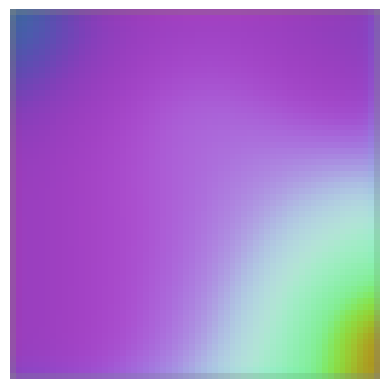

In [16]:
# Cell 7 — generate images from a checkpoint or trained model
from PIL import Image
import matplotlib.pyplot as plt
ckpt = torch.load("./pgan_checkpoints/pgan_checkpoint_res64.pt", map_location=device)
G.load_state_dict(ckpt['G_state'])
G.eval()
z = torch.randn(16, z_dim, device=device)
with torch.no_grad():
    imgs = G(z, step=4, alpha=1.0).cpu()   # step 4 -> 64x64
# save grid
save_image_grid(imgs, "./pgan_checkpoints/generated64.png", nrow=4)
# show one sample in notebook
grid = (imgs[0]+1)/2
plt.imshow(grid.permute(1,2,0).numpy())
plt.axis('off')


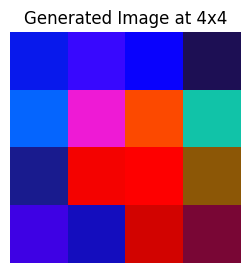

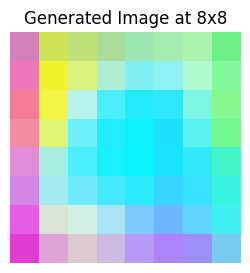

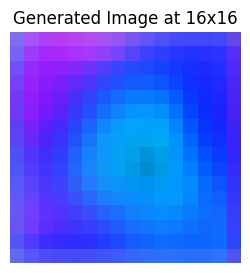

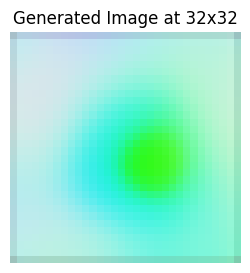

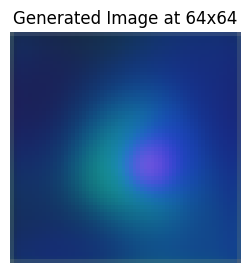

In [20]:
# =========================
# Generate images at all PGGAN stages
# =========================

from PIL import Image
import matplotlib.pyplot as plt

# Load checkpoint
ckpt = torch.load("./pgan_checkpoints/pgan_checkpoint_res64.pt", map_location=device)
G.load_state_dict(ckpt['G_state'])
G.eval()

# Fixed latent vector for reproducibility
fixed_z = torch.randn(16, z_dim, device=device)

# Define resolutions corresponding to steps
resolutions = [4, 8, 16, 32, 64]

# Directory to save generated grids
os.makedirs("./pgan_checkpoints/progressive_samples", exist_ok=True)

# Generate and display images for each step
for step, res in enumerate(resolutions):
    alpha = 1.0  # full alpha for stable generation
    with torch.no_grad():
        imgs = G(fixed_z, step=step, alpha=alpha).cpu()
        # save grid
        save_image((imgs + 1)/2.0, f"./pgan_checkpoints/progressive_samples/generated_{res}x{res}.png", nrow=4)

    # Display one sample (first image in batch)
    grid = (imgs[0] + 1)/2.0
    plt.figure(figsize=(3,3))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis('off')
    plt.title(f"Generated Image at {res}x{res}")
    plt.show()
